In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from scipy.stats import probplot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('stock_data.csv')
# changing dates timestamp so it's easier to graph/predict in the future, and getting just the needed data for our model. 
# made smaller than before so sklearn doesnt have floatingpoint errors
data = df[['Date', 'Close', 'Sector']].copy()
data.Date = pd.to_datetime(df.Date, utc=True).dt.tz_convert(None).astype('int64') / 10**17
data = data[['Date', 'Close']].groupby('Date').mean()
data.reset_index(inplace=True, drop=False)

Text(0, 0.5, 'MSE')

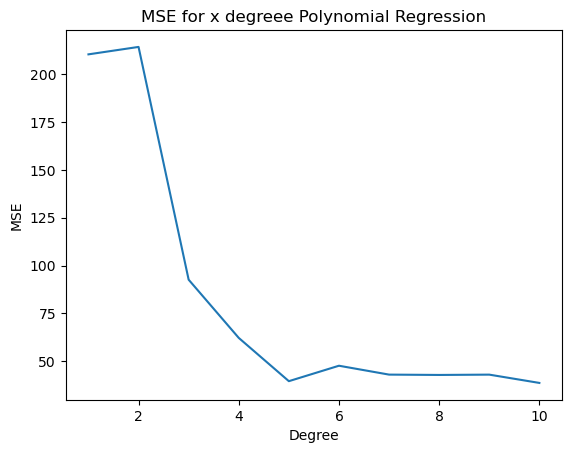

In [3]:
from sklearn.preprocessing import StandardScaler
x = data.Date.to_numpy().reshape(-1,1)
y = data.Close

results = dict()
for i in range(1, 11):
    #create poly features
    poly = PolynomialFeatures(degree=i, include_bias=False)
    xp = poly.fit_transform(x)

    X_train, X_test, y_train, y_test = train_test_split(xp, y, train_size = 0.733)

    #create a model and predict
    model = LinearRegression()
    model.fit(X_train, y_train)

    #predicted and actual vals
    pred = model.predict(X_test)
    actual = y_test.to_numpy()

    #get resids, mse, r2
    resids = actual - pred
    mse = mean_squared_error(actual, pred)
    r2 = r2_score(actual, pred)

    results[i] = {'pred':pred, 'actual':actual, 'resids':resids, 'mse':mse, 'r2':r2, 'x':X_test, 'model':model}

mses = []
degrees = []
for i in results.keys():
    mses.append(results[i]['mse'])
    degrees.append(i)
plt.plot(degrees, mses)
plt.title('MSE for x degreee Polynomial Regression')
plt.xlabel('Degree')
plt.ylabel('MSE')

Diminishing returns after 4 degrees, just overfitting more and more, so we will go with a 6 degree polynomial

In [4]:
def print_diagnostics(pred, resids, model_name = "model"):
    
    
    # Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # 1. Constant Variance
    plt.subplot(2, 2, 1)
    plt.scatter(pred, resids, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted (Constant Variance)')

    # 2. Residuals vs index/order (Independence)
    index = range(len(pred))
    plt.subplot(2, 2, 2)
    plt.scatter(index, resids, alpha=0.5)  # Use first column if multi-feature
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Time (or X)')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Time (Independence)')

    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(resids, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normality')

    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    sns.histplot(resids, kde=True, bins=30, color='green', alpha=0.6)
    plt.xlabel('Residuals')
    plt.title('Histogram of Residuals')


    plt.suptitle(f"{model_name} Diagnostic Plots", fontsize=16)
    plt.tight_layout()
    plt.show()

In [7]:
model_results = results[4]

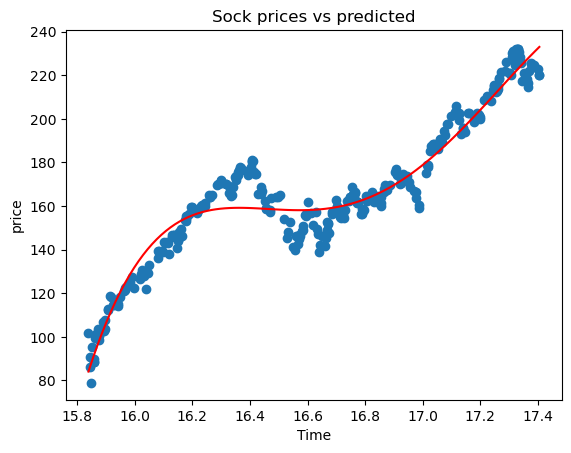

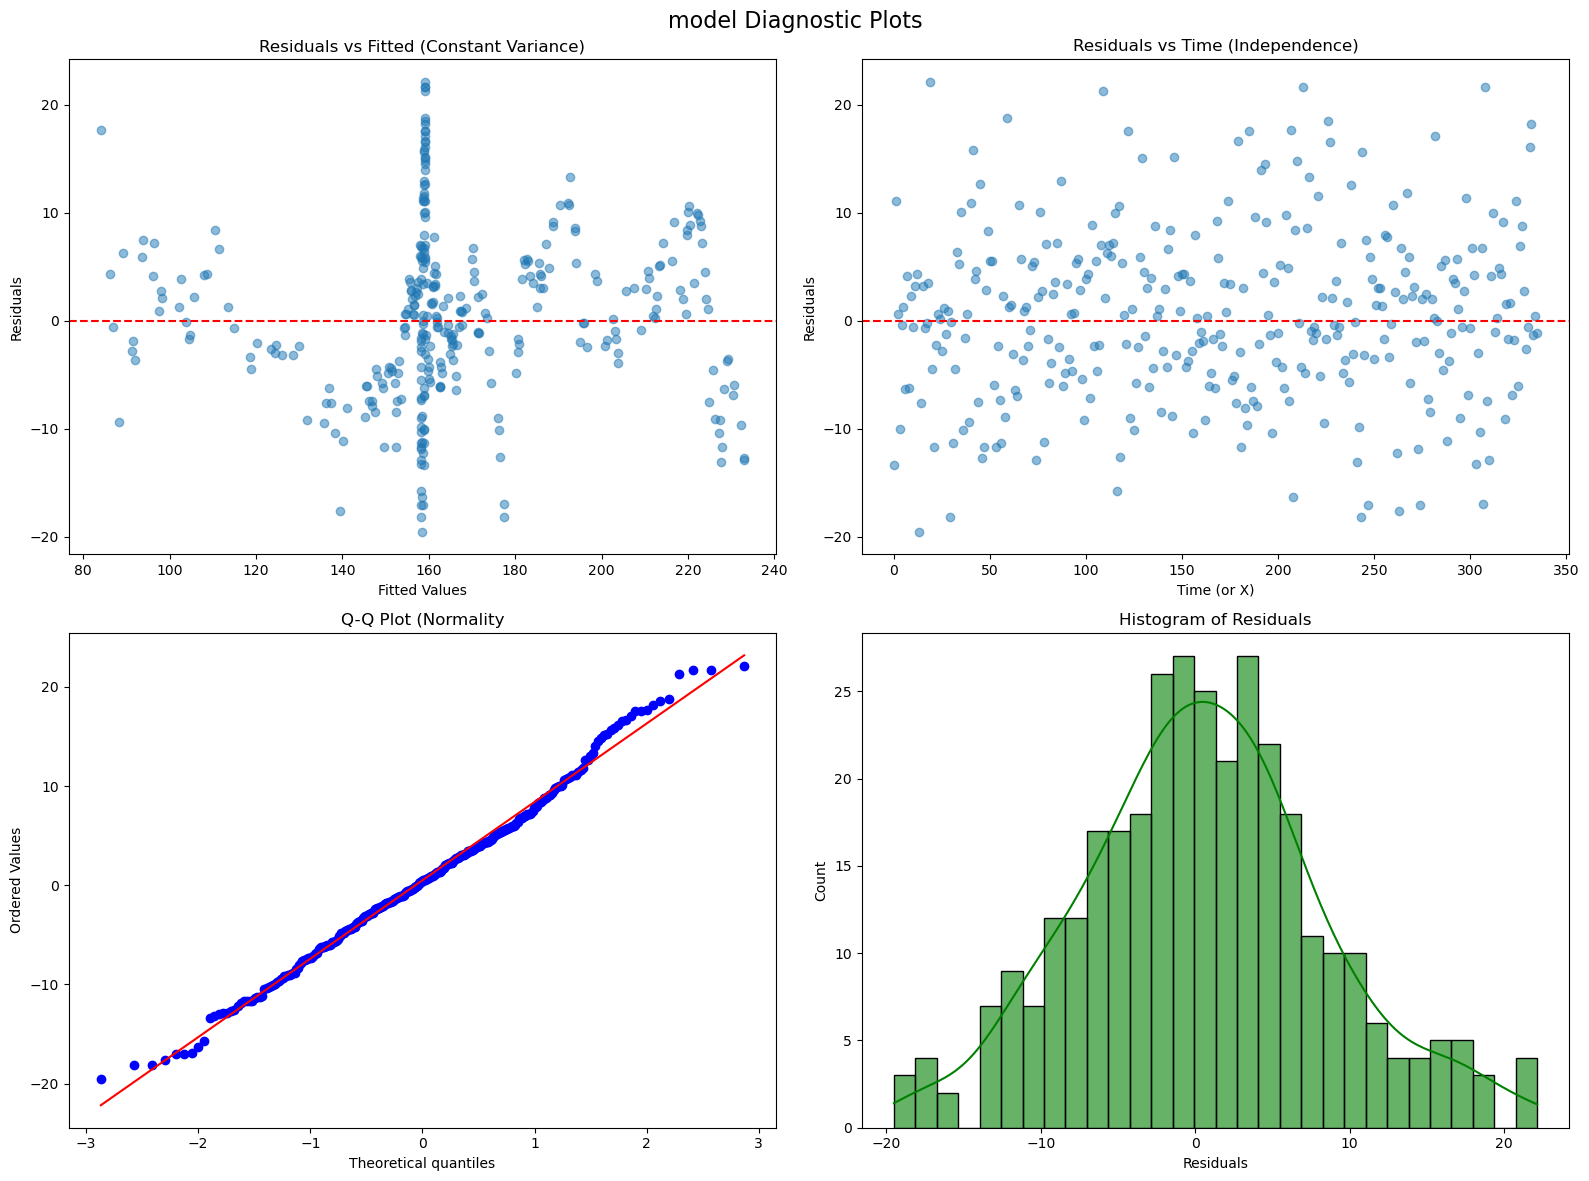

62.248502770782686 0.9415031669840034


In [6]:
import numpy as np
fig = plt.figure()
dates = model_results['x'].T[0]
plt.scatter(dates, model_results['actual'])
min_x = min(dates)
max_x = max(dates)
x_spread = np.linspace(min_x, max_x, 100)
plt.plot(x_spread, model_results['model'].predict(PolynomialFeatures(4, include_bias=False).fit_transform(x_spread.reshape(-1,1))), color='red')
plt.title('Sock prices vs predicted')
plt.xlabel('Time')
plt.ylabel('price')
print_diagnostics(model_results['pred'], model_results['resids'])
print(model_results['mse'], model_results['r2'])